# Introduction

In this notebook I explore using my MP-Iteration to solve the problem given as equation (4.1) in [This Niall Madden Paper](https://jadler.math.tufts.edu/publications/files/2015_SingPert_IMAJNA.pdf).
Note that I make use of the matrix form of a Bakhvalov Mesh Density Function. I also have an option to implement HR (5.191) instead!

# Results

We see that the Bakhvalov M leads to a nice mesh. However, we want a solution dependent M. Therefore, the mesh we get from the Bakhvalov Mesh Density Function is used as a guide for what we would like our solution dependent M to produce! It also helped show us that our gradient based M was not cutting it (did not look as good as the B type mesh we produce here!).

# Imports

In [1]:
# install firedrake

# hide output
%%capture

try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# The Known Solution

In [4]:
def known_solution(x, epsilon):


  eps = Constant(epsilon)

  parta = cos((pi/2)*x[0]) - ( exp(-x[0]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )
  partb = 1 - x[1] - ( exp(-x[1]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )
  u_exact = parta*partb


  return u_exact

# Physical Solver

In [5]:

# phyiscal solver

def physical_solver(mesh, x, W, known_solution, epsilon = 0.1, plots = True, Bak_M = True, Grad_M = False):

  # test and trial functions

  u_hat = TrialFunction(W)
  v_hat = TestFunction(W)


  # set f (rhs of pde)


  eps = Constant(epsilon)

  # f_hat = -eps**2*((-pi**2*cos(pi*x[0]/2)/4 - exp(-x[0]/eps)/(eps**2*(1 - exp(-1/eps))))*(-x[1] + 1 - (exp(-x[1]/eps) - exp(-1/eps))/(1 - exp(-1/eps))) - (cos(pi*x[0]/2) - (exp(-x[0]/eps) - exp(-1/eps))/(1 - exp(-1/eps)))*exp(-x[1]/eps)/(eps**2*(1 - exp(-1/eps)))) + (cos(pi*x[0]/2) - (exp(-x[0]/eps) - exp(-1/eps))/(1 - exp(-1/eps)))*(-x[1] + 1 - (exp(-x[1]/eps) - exp(-1/eps))/(1 - exp(-1/eps)))


  # The jacobian matrix of the mesh solution x

  J_F = grad(x) # jacobian matrix


  #pull components out
  x_xi = J_F[0,0]
  x_eta = J_F[0,1]
  y_xi = J_F[1,0]
  y_eta = J_F[1,1]

  # determinant
  det_J = x_xi * y_eta - x_eta * y_xi


  # inverse of the jacobian

  J_F_inv = inv(J_F)
  J_F_inv_T = transpose(J_F_inv)

  # Compute the rhs of the PDE

  a1 = (1/det_J) * as_vector([y_eta, -x_eta]) # HR (3.28)
  a2 = (1/det_J) * as_vector([-y_xi, x_xi]) # HR (3.29)

  grad_xi_sol = grad( known_solution(x, epsilon) )
  grad_x_sol = dot(J_F_inv_T, grad_xi_sol) # Based on HR (3.8) # transform gradient

  val1 = inner( det_J * a1 , grad_x_sol ) # Based on HR (3.9) # transform divergence
  val2 = inner( det_J * a2 , grad_x_sol ) # Based on HR (3.9)

  div_term = (1/det_J) * div( as_vector([val1, val2]) ) # the transformed divergence

  f_hat = -eps**2 * div_term + known_solution(x, epsilon) # the rhs


  # f_hat = -eps**2 * div( dot( J_F_inv_T, grad( known_solution(x, epsilon) ) ) ) + known_solution(x, epsilon)


  # compute grad_(x) of u (HR 3.8)

  grad_x_u = dot(J_F_inv_T, grad(u_hat))


  # compute grad_(x) of v (HR 3.8)

  grad_x_v = dot(J_F_inv_T, grad(v_hat))


  # The bilinear lhs

  a = ( (eps**2) * inner( grad_x_u, grad_x_v) + inner(u_hat, v_hat) ) * det_J * dx

  # The linear rhs

  L = (inner( f_hat, v_hat ) * det_J) * dx



  # define the BC's


  # bcy1 = (cos((pi/2)*0) - ( exp(-0/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )) * ( 1 - x[1] - ( exp(-x[1]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) ) )
  # bcy2 = (cos((pi/2)*1) - ( exp(-1/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )) * ( 1 - x[1] - ( exp(-x[1]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) ) )
  # bcx1 = (cos((pi/2)*x[0]) - ( exp(-x[0]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )) * ( 1 - 0 - ( exp(-0/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) ) )
  # bcx2 = (cos((pi/2)*x[0]) - ( exp(-x[0]/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) )) * ( 1 - 1 - ( exp(-1/eps) - exp(-1/eps) ) / ( 1 - exp(-1/eps) ) )
  # bc1 = DirichletBC(W, bcy1 , 1) #left
  # bc2 = DirichletBC(W, bcy2 , 2) #right
  # bc3 = DirichletBC(W, bcx1 , 3) #bottom
  # bc4 = DirichletBC(W, bcx2 , 4) #top
  # bcs = [ bc1, bc2, bc3, bc4]


  bcs = DirichletBC(W, known_solution(x, epsilon), "on_boundary" )


  # solve the problem

  sol = Function(W)


  solve(a == L, sol, bcs = bcs)


  # exact solution

  exact_sol = known_solution(x, epsilon)


  # L2 error

  phys_error_1 = norm( sqrt(det_J) * (exact_sol - sol) )
  # phys_error_2 = norm( sqrt(det_J) * dot(J_F_inv_T ,grad(exact_sol - sol)))
  phys_error_2 = norm(  sqrt(epsilon) * sqrt(det_J) * dot(J_F_inv_T , grad(exact_sol - sol)) )





  if Bak_M:
    # Bakhvalov Mesh Density Matrix

    K0 = 0.4 # weight of points in layers
    K1 = 0.4
    rho = 0.99  # c >= rho^2
    sigma = 2.5  # sigma > order of FEM + 1

    Mt1 = K0 * rho * (1/eps) * ( exp( (-rho*x[0]) / (sigma*eps) ) )
    Mt2 = K1 * rho * (1/eps) * ( exp( (-rho*x[1]) / (sigma*eps) ) )

    m0 = 1 + Mt1
    m1 = 1 + Mt2

    M = as_matrix([[m0, 0], [0, m1]])



  if Grad_M: # Based on HR (5.191)

    # Define M

    alpha_hat = Constant(1)

    grad_xi_sol = dot(J_F_inv_T, grad(sol))


    alpha_a = assemble(alpha_hat**2 * ( ((sol)**2)* det_J * dx ))

    alpha_b = assemble( ( inner( grad_xi_sol, grad_xi_sol)**(1/4) ) * det_J * dx )**4

    alpha = max(alpha_a , alpha_b)

    M_a = ( 1 + (1/(alpha)) * inner(grad_xi_sol, grad_xi_sol) )**(-1/4)

    M_b = ( Identity(2) + (1/alpha) * outer( grad_xi_sol, grad_xi_sol ) )

    M = M_a * M_b

    if alpha == alpha_a :
      print('Used term 1 for alpha')
      print('alpha = ', alpha)
      print()

    if alpha == alpha_b:
      print('Used term 2 for alpha')
      print('alpha = ', alpha)
      print()



  # return the solution and the mesh density function


  return sol, M, phys_error_1, phys_error_2

# Mesh Solver (Matrix Form w/o 1/|J|)

In [6]:
# # OLD MESH SOLVE - USES 1/|J|


# def mesh_solver_withJ(xi, eta, M, x, V, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


#   # function to hold mesh solution
#   mesh_sol = Function(V)
#   # pull out x and y mesh solutions
#   mesh_sol_x = mesh_sol[0]
#   mesh_sol_y = mesh_sol[1]
#   # gradient of x solution and y solution w.r.t (xi, eta)
#   new_gradx = grad(mesh_sol_x)
#   new_grady = grad(mesh_sol_y)
#   # pull out terms of the gradients
#   new_x_xi = new_gradx[0]
#   new_x_eta = new_gradx[1]
#   new_y_xi = new_grady[0]
#   new_y_eta = new_grady[1]


#   # jacobian

#   new_det_J = new_x_xi * new_y_eta - new_x_eta * new_y_xi


#   # a1 and a2

#   a_1 = (1/new_det_J) * as_vector([new_y_eta, -new_x_eta])
#   a_2 = (1/new_det_J) * as_vector([-new_y_xi, new_x_xi])


#   # inverse of M

#   M_inv = inv(M)


#   # problem vectors


#   u1_0 = inner(new_det_J * a_1, dot(M_inv, a_1))
#   u1_1 = inner(new_det_J * a_2, dot(M_inv, a_1))

#   u2_0 = inner(new_det_J * a_1, dot(M_inv, a_2))
#   u2_1 = inner(new_det_J * a_2, dot(M_inv, a_2))

#   u1 = as_vector([u1_0, u1_1])
#   u2 = as_vector([u2_0, u2_1])


#   # create problem

#   # test functions

#   v = TestFunction(V)
#   v1 = v[0]
#   v2 = v[1]


#   # Eqn 1

#   a1 = (inner(u1, grad(v1/new_det_J)))


#   # Eqn 2

#   a2 = (inner(u2, grad(v2/new_det_J)))


#   # The equation we solve , F==0

#   F = (a1 + a2)*dx


#   # The initial guess (current (x,y) mesh)

#   mesh_sol.assign(project(as_vector([x[0], x[1]]), V))


#   # the bc's

#   bc1 = DirichletBC(V.sub(0), Constant(0), 1) # x=0 on left side
#   bc2 = DirichletBC(V.sub(0), Constant(1), 2) # x=1 on right side
#   bc3 = DirichletBC(V.sub(1), Constant(0), 3) # y=0 on bottom
#   bc4 = DirichletBC(V.sub(1), Constant(1), 4) # y=1 on top

#   bcs = [bc1, bc2, bc3, bc4]


#   # Solve, NewtonLS

#   print("-"*125)
#   print("Nonlinear Mesh Solve:")

#   # solve(F==0, mesh_sol, bcs = bcs, \
#   #          solver_parameters = {'snes_converged_reason': None,\
#   #                               'snes_monitor': None,\
#   #                               "snes_stol": stol,\
#   #                               "snes_rtol": rtol,\
#   #                               "snes_atol": atol,\
#   #                               "snes_max_it": maxit,\
#   #                               "snes_norm_type:" : 3})


#   solve(F==0, mesh_sol, bcs = bcs, \
#           solver_parameters = {'snes_converged_reason': None,\
#                               'snes_monitor': None,\
#                               "snes_stol": stol,\
#                               "snes_rtol": rtol,\
#                               "snes_atol": atol,\
#                               "snes_max_it": maxit})

#   print("-"*125)
#   print()
#   print()



#   # evaluate the xy solution so I can plot it


#   # solution data
#   old_mesh_vals = mesh.coordinates.dat.data
#   xsol = np.array(mesh_sol.at(old_mesh_vals))[:,0]
#   ysol = np.array(mesh_sol.at(old_mesh_vals))[:,1]
#   # create mesh
#   initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
#   nx = len(xsol)
#   new_mesh_vals = np.zeros((nx, 2))
#   new_mesh_vals[:,0] = xsol
#   new_mesh_vals[:,1] = ysol
#   initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals

#   # plot computational and physical mesh

#   fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#   # computational grid
#   xi_plot = triplot(mesh, axes=axes[0])
#   axes[0].set_title('Computational Grid')
#   axes[0].set_xlabel(r"$\xi$")
#   axes[0].set_ylabel(r"$\eta$")
#   axes[0].set_aspect('equal')

#   # physical grid
#   x_plot = triplot(initial_phys_mesh, axes=axes[1])
#   axes[1].set_title('Solution for x')
#   axes[1].set_xlabel(r"$x$")
#   axes[1].set_ylabel(r"$y$")
#   axes[1].set_aspect('equal')

#   plt.tight_layout()
#   plt.show()

#   print()
#   print()




#   return mesh_sol


In [7]:
# mesh solver


def mesh_solver_noJ(xi, eta, M_matrix, x, V, deg = 1, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # function to hold mesh solution
  mesh_sol = Function(V)

  # Jacobian

  J_matrix = grad(mesh_sol)
  detJ = det(J_matrix)

  # JMJ part

  # transformed gradient and divergence in Winslow (HR (6.131))
  # using either (3.8) and (3.9) or
  # using (6.131), (6.132), (6.133), in (6.15)
  JMJ_matrix = transpose(J_matrix) * M_matrix * J_matrix
  JMJ_inv = inv(JMJ_matrix)



  # create problem

  # test function

  v = TestFunction(V)


  # Eqn

  pt1 = inner(transpose(grad(v)), detJ * JMJ_inv) * dx

  #pt2 = inner(dot(detJ * JMJ_inv, v), n) * ds

  # Orthogonlaity enforced
  BI1 = (-(J_matrix[1, 1] * M_matrix[0, 0] * v[0])/ J_matrix[0, 0])*ds(1)
  BI2 = ((J_matrix[1, 1] * M_matrix[0, 0] * v[0])/ J_matrix[0, 0])*ds(2)
  BI3 = (-(J_matrix[0, 0] * M_matrix[1, 1] * v[1])/ J_matrix[1, 1])*ds(3)
  BI4 = ((J_matrix[0, 0] * M_matrix[1, 1] * v[1])/ J_matrix[1, 1])*ds(4)

  BI = BI1 + BI2 + BI3 + BI4
  # F = pt1 - BI
  F = pt1 # the boundary integrals evaliuate to zero because v[0]=0 on (1), (2) and v[1] = 0 on (3),(4)


  # The initial guess (current (x,y) mesh)

  mesh_sol.interpolate(as_vector([x[0], x[1]]))


  # the Dirichlet bc's


  bc1 = DirichletBC(V.sub(0), Constant(0), 1) # x=0 on left side
  bc2 = DirichletBC(V.sub(0), Constant(1), 2) # x=1 on right side
  bc3 = DirichletBC(V.sub(1), Constant(0), 3) # y=0 on bottom
  bc4 = DirichletBC(V.sub(1), Constant(1), 4) # y=1 on top
  bcs = [bc1, bc2, bc3, bc4]



  # Solve, NewtonLS

  print("-"*125)
  print("Nonlinear Mesh Solve:")



  solve(F == 0, mesh_sol, bcs = bcs, \
          solver_parameters = {'snes_converged_reason': None,\
                              'snes_monitor': None,\
                              "snes_stol": stol,\
                              "snes_rtol": rtol,\
                              "snes_atol": atol,\
                              "snes_max_it": maxit})

  print("-"*125)
  print()
  print()


  return mesh_sol


In [8]:
# USED ONLY FOR A SPECIAL TEST - After solving with B M we take final result and apply (5.191)


def extra_mesh_solver_noJ(xi, eta, M_matrix, x, x_old, V, deg = 1, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # function to hold mesh solution
  mesh_sol = Function(V)

  # Jacobian

  J_matrix = grad(mesh_sol)
  detJ = det(J_matrix)

  # JMJ part

  # JMJ_matrix = dot(dot(transpose(J_matrix),M_matrix) , J_matrix)
  JMJ_matrix = transpose(J_matrix) * M_matrix * J_matrix
  JMJ_inv = inv(JMJ_matrix)



  # create problem

  # test function

  v = TestFunction(V)


  # Eqn

  pt1 = inner(transpose(grad(v)), detJ * JMJ_inv) * dx



  # The initial guess (current (x,y) mesh)

  mesh_sol.interpolate(as_vector([x[0], x[1]]))


  # the Dirichlet bc's
  # Set Bakhvalov mesh on boundaries

  bcs = DirichletBC(V, x_old, "on_boundary")

  # F

  F = pt1



  # Solve, NewtonLS

  print("-"*125)
  print("Nonlinear Mesh Solve:")



  solve(F == 0, mesh_sol, bcs = bcs, \
          solver_parameters = {'snes_converged_reason': None,\
                              'snes_monitor': None,\
                              "snes_stol": stol,\
                              "snes_rtol": rtol,\
                              "snes_atol": atol,\
                              "snes_max_it": maxit,\
                               "snes_linesearch_type": "l2",\
                               "snes_linesearch_monitor": None})

  print("-"*125)
  print()
  print()


  return mesh_sol


# MP-Iteration Code

In [9]:
# MP - Iteration Code that uses differant mesh solve

def MP_iter_woJ(mesh, xi, eta, W, V, x, N, known_solution, iter_count, epsilon, deg = 1, plot_phys = True, plot_mesh = True, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # set up for the loop
  # list to save physical erros

  phys_l2_errors = []
  phys_grad_errors = []


  # set the loop for the set number of MP iterations

  for i in range(iter_count):


    # physical solve

    phys_sol, M, phys_error_1, phys_error_2 = physical_solver(mesh, x, W, known_solution, epsilon, plots = plot_phys)


    # save errors

    phys_l2_errors.append(phys_error_1)
    phys_grad_errors.append(phys_error_2)


    # Mesh Solve

    mesh_sol = mesh_solver_noJ(xi, eta, M, x, V, deg = deg, rtol = rtol, stol = stol, atol = atol, maxit = maxit)


    # analyize mesh convergence

    if i > 0:

      mesh_check = norm(mesh_sol - x)


    # UPDATE x

    x = mesh_sol


  # do a final physical solve on the last mesh

  phys_sol, M, phys_error_1, phys_error_2 = physical_solver(mesh, x, W, known_solution, epsilon, plots = plot_phys)
  phys_l2_errors.append(phys_error_1)
  phys_grad_errors.append(phys_error_2)



  return x, phys_l2_errors, phys_grad_errors, phys_sol, M

In [10]:
# MP - Iteration Code that uses differant mesh solve
# USED ONLY FOR A SPECIAL TEST - After solving with B M we take final result and apply (5.191)

def extra_MP_iter_woJ(mesh, xi, eta, W, V, x, x_old, N, known_solution, iter_count, epsilon, deg = 1, plot_phys = True, plot_mesh = True, rtol = 1e-8, stol = 1e-8, atol = 1e-50, maxit = 10):


  # set up for the loop
  # list to save physical erros

  phys_l2_errors = []
  phys_grad_errors = []


  # set the loop for the set number of MP iterations

  for i in range(iter_count):



    # physical solve - change to gradient M

    phys_sol, M, phys_error_1, phys_error_2 = physical_solver(mesh, x, W, known_solution, epsilon, plots = plot_phys, Bak_M = False, Grad_M = True)


    # save errors

    phys_l2_errors.append(phys_error_1)
    phys_grad_errors.append(phys_error_2)


    # Mesh Solve

    mesh_sol = extra_mesh_solver_noJ(xi, eta, M, x, x_old, V, deg = deg, rtol = rtol, stol = stol, atol = atol, maxit = maxit)


    # analyize mesh convergence

    if i > 0:

      mesh_check = norm(mesh_sol - x)


    # UPDATE x

    x = mesh_sol


  # do a final physical solve on the last mesh

  phys_sol, M, phys_error_1, phys_error_2 = physical_solver(mesh, x, W, known_solution, epsilon, plots = plot_phys)
  phys_l2_errors.append(phys_error_1)
  phys_grad_errors.append(phys_error_2)



  return x, phys_l2_errors, phys_grad_errors, phys_sol, M

# The Test

## MP-Iteration + Continuation + Bakhvalov M

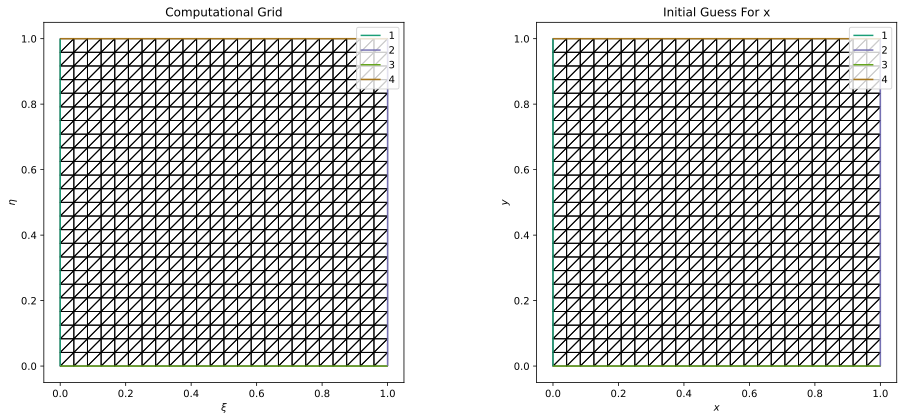



____________________________________________________________ epsilon = 0.5 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.018715200677e-02
  1 SNES Function norm 2.019556756663e-03
  2 SNES Function norm 3.998862213970e-05
  3 SNES Function norm 1.731806932192e-08
  4 SNES Function norm 3.279684554414e-15
  Nonlinear firedrake_1_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.45 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.690314320833e-03
  1 SNES Function norm 4.597550516206e-05
  2 SNES Function norm 1.877193925655e-08
  3 SNES Function norm 4.168619199029e-15
  Nonlinear firedrake_4_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.405 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.723902877425e-03
  1 SNES Function norm 5.425017372629e-05
  2 SNES Function norm 2.855788552099e-08
  3 SNES Function norm 9.354096593288e-15
  Nonlinear firedrake_7_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.36450000000000005 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.888590664497e-03
  1 SNES Function norm 6.671828953285e-05
  2 SNES Function norm 4.493415739482e-08
  3 SNES Function norm 2.438312964608e-14
  Nonlinear firedrake_10_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.32805000000000006 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.055573245364e-03
  1 SNES Function norm 8.108353332915e-05
  2 SNES Function norm 6.916043961358e-08
  3 SNES Function norm 6.102192245545e-14
  Nonlinear firedrake_13_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.2952450000000001 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.227173102150e-03
  1 SNES Function norm 9.760323334886e-05
  2 SNES Function norm 1.046254216563e-07
  3 SNES Function norm 1.478583029373e-13
  Nonlinear firedrake_16_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.2657205000000001 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.402263221333e-03
  1 SNES Function norm 1.163145059953e-04
  2 SNES Function norm 1.552400431945e-07
  3 SNES Function norm 3.445384651119e-13
  Nonlinear firedrake_19_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.23914845000000007 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.579522081475e-03
  1 SNES Function norm 1.372143744179e-04
  2 SNES Function norm 2.258363359591e-07
  3 SNES Function norm 7.705963525831e-13
  Nonlinear firedrake_22_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.21523360500000008 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.757609046336e-03
  1 SNES Function norm 1.602356439901e-04
  2 SNES Function norm 3.219826474465e-07
  3 SNES Function norm 1.651873681943e-12
  Nonlinear firedrake_25_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.19371024450000007 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.935414090905e-03
  1 SNES Function norm 1.852540260257e-04
  2 SNES Function norm 4.496694973839e-07
  3 SNES Function norm 3.387682376203e-12
  Nonlinear firedrake_28_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.17433922005000008 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.112529689399e-03
  1 SNES Function norm 2.121091926913e-04
  2 SNES Function norm 6.147424493900e-07
  3 SNES Function norm 6.632335531476e-12
  Nonlinear firedrake_31_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.15690529804500009 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.289958266903e-03
  1 SNES Function norm 2.406303406991e-04
  2 SNES Function norm 8.220608562153e-07
  3 SNES Function norm 1.236539420195e-11
  Nonlinear firedrake_34_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.14121476824050008 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.470936588076e-03
  1 SNES Function norm 2.706461394539e-04
  2 SNES Function norm 1.074482210544e-06
  3 SNES Function norm 2.189813878634e-11
  Nonlinear firedrake_37_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 3
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.12709329141645007 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.661509667388e-03
  1 SNES Function norm 3.019545675039e-04
  2 SNES Function norm 1.371911498919e-06
  3 SNES Function norm 3.674617809758e-11
  4 SNES Function norm 1.529508994125e-15
  Nonlinear firedrake_40_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.11438396227480506 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.870238215479e-03
  1 SNES Function norm 3.342504587035e-04
  2 SNES Function norm 1.710681027658e-06
  3 SNES Function norm 5.832030008599e-11
  4 SNES Function norm 1.285543924571e-15
  Nonlinear firedrake_43_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.10294556604732455 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.106506333583e-03
  1 SNES Function norm 3.670607338709e-04
  2 SNES Function norm 2.083356488504e-06
  3 SNES Function norm 8.747485025357e-11
  4 SNES Function norm 1.407972576135e-15
  Nonlinear firedrake_46_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0926510094425921 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.377673529438e-03
  1 SNES Function norm 3.997746040055e-04
  2 SNES Function norm 2.478951737162e-06
  3 SNES Function norm 1.240824968740e-10
  4 SNES Function norm 1.402060402561e-15
  Nonlinear firedrake_49_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.08338590849833288 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.686534281705e-03
  1 SNES Function norm 4.318072181623e-04
  2 SNES Function norm 2.883809850556e-06
  3 SNES Function norm 1.668794856256e-10
  4 SNES Function norm 1.323554579590e-15
  Nonlinear firedrake_52_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0750473176484996 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 5.030980500737e-03
  1 SNES Function norm 4.628098736536e-04
  2 SNES Function norm 3.283641340056e-06
  3 SNES Function norm 2.137359782890e-10
  4 SNES Function norm 1.238272650522e-15
  Nonlinear firedrake_55_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.06754258588364964 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 5.406406543014e-03
  1 SNES Function norm 4.927764604983e-04
  2 SNES Function norm 3.666515729328e-06
  3 SNES Function norm 2.622659031019e-10
  4 SNES Function norm 1.250974022675e-15
  Nonlinear firedrake_58_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.06078832729528468 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 5.809220158415e-03
  1 SNES Function norm 5.219933877754e-04
  2 SNES Function norm 4.025480260542e-06
  3 SNES Function norm 3.104834313875e-10
  4 SNES Function norm 1.177128519503e-15
  Nonlinear firedrake_61_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.05470949456575622 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 6.239026564462e-03
  1 SNES Function norm 5.509186698682e-04
  2 SNES Function norm 4.359457702295e-06
  3 SNES Function norm 3.572080455597e-10
  4 SNES Function norm 1.194589993195e-15
  Nonlinear firedrake_64_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0492385451091806 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 6.698394383793e-03
  1 SNES Function norm 5.800833131839e-04
  2 SNES Function norm 4.672214451372e-06
  3 SNES Function norm 4.020998974590e-10
  4 SNES Function norm 1.126370159534e-15
  Nonlinear firedrake_67_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.04431469059826254 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 7.191086408383e-03
  1 SNES Function norm 6.100277691351e-04
  2 SNES Function norm 4.970204598188e-06
  3 SNES Function norm 4.454173991180e-10
  4 SNES Function norm 1.176750024750e-15
  Nonlinear firedrake_70_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.039883221538436285 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 7.720388091782e-03
  1 SNES Function norm 6.412550288934e-04
  2 SNES Function norm 5.260352453713e-06
  3 SNES Function norm 4.876867956572e-10
  4 SNES Function norm 1.218038678140e-15
  Nonlinear firedrake_73_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.03589489938459266 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 8.288434195923e-03
  1 SNES Function norm 6.742002559984e-04
  2 SNES Function norm 5.548520643038e-06
  3 SNES Function norm 5.294410824990e-10
  4 SNES Function norm 1.140721128398e-15
  Nonlinear firedrake_76_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.032305409446133394 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 8.896375692419e-03
  1 SNES Function norm 7.092220569418e-04
  2 SNES Function norm 5.838985829299e-06
  3 SNES Function norm 5.710925879369e-10
  4 SNES Function norm 1.131564744900e-15
  Nonlinear firedrake_79_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.029074868501520055 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 9.544814393746e-03
  1 SNES Function norm 7.466140381062e-04
  2 SNES Function norm 6.135223897995e-06
  3 SNES Function norm 6.129249232075e-10
  4 SNES Function norm 1.126761759357e-15
  Nonlinear firedrake_82_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.02616738165136805 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.023410726718e-02
  1 SNES Function norm 7.865957289615e-04
  2 SNES Function norm 6.439590119789e-06
  3 SNES Function norm 6.551317548553e-10
  4 SNES Function norm 1.176485657422e-15
  Nonlinear firedrake_85_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.023550643486231246 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.096444195504e-02
  1 SNES Function norm 8.292126253653e-04
  2 SNES Function norm 6.750400471089e-06
  3 SNES Function norm 6.978698887466e-10
  4 SNES Function norm 1.234454653563e-15
  Nonlinear firedrake_88_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.021195579137608122 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.173610714854e-02
  1 SNES Function norm 8.747268131371e-04
  2 SNES Function norm 7.069626210807e-06
  3 SNES Function norm 7.413579660006e-10
  4 SNES Function norm 1.145180834637e-15
  Nonlinear firedrake_91_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.01907602122384731 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.254996625442e-02
  1 SNES Function norm 9.245060406397e-04
  2 SNES Function norm 7.413947670486e-06
  3 SNES Function norm 7.858449220919e-10
  4 SNES Function norm 1.121177188559e-15
  Nonlinear firedrake_94_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.01716841910146258 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.340449134253e-02
  1 SNES Function norm 9.780219183693e-04
  2 SNES Function norm 7.790764166500e-06
  3 SNES Function norm 8.314836384452e-10
  4 SNES Function norm 1.165178687364e-15
  Nonlinear firedrake_97_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.015451577191316321 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.429038784415e-02
  1 SNES Function norm 1.027419750217e-03
  2 SNES Function norm 8.170190081513e-06
  3 SNES Function norm 8.785616412257e-10
  4 SNES Function norm 1.146192185167e-15
  Nonlinear firedrake_100_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.01390641947218469 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.520397959881e-02
  1 SNES Function norm 1.066206786933e-03
  2 SNES Function norm 8.524991223213e-06
  3 SNES Function norm 9.278433792965e-10
  4 SNES Function norm 1.145473726203e-15
  Nonlinear firedrake_103_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.012515777524966222 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.618362382906e-02
  1 SNES Function norm 1.110623808153e-03
  2 SNES Function norm 8.894475087743e-06
  3 SNES Function norm 9.802358713387e-10
  4 SNES Function norm 1.098381548247e-15
  Nonlinear firedrake_106_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0112641997724696 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.730022759034e-02
  1 SNES Function norm 1.195521555916e-03
  2 SNES Function norm 9.365706788145e-06
  3 SNES Function norm 1.035885250898e-09
  4 SNES Function norm 1.140556836880e-15
  Nonlinear firedrake_109_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.010137779795222639 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.854420559286e-02
  1 SNES Function norm 1.328401465535e-03
  2 SNES Function norm 9.980141261278e-06
  3 SNES Function norm 1.093895814512e-09
  4 SNES Function norm 1.105811068605e-15
  Nonlinear firedrake_112_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.009124001815700375 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 1.971800214680e-02
  1 SNES Function norm 1.463591698342e-03
  2 SNES Function norm 1.065029071927e-05
  3 SNES Function norm 1.153421324475e-09
  4 SNES Function norm 1.136950049178e-15
  Nonlinear firedrake_115_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.008211601634130337 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.051753790737e-02
  1 SNES Function norm 1.537235184668e-03
  2 SNES Function norm 1.119183026460e-05
  3 SNES Function norm 1.215160181916e-09
  4 SNES Function norm 1.052754258981e-15
  Nonlinear firedrake_118_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.007390441470717304 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.080926769139e-02
  1 SNES Function norm 1.516204432628e-03
  2 SNES Function norm 1.154643533392e-05
  3 SNES Function norm 1.282115656984e-09
  4 SNES Function norm 1.260018318309e-15
  Nonlinear firedrake_121_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.006651397323645574 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.090602257646e-02
  1 SNES Function norm 1.415367896591e-03
  2 SNES Function norm 1.187775184050e-05
  3 SNES Function norm 1.358664331733e-09
  4 SNES Function norm 1.136588919823e-15
  Nonlinear firedrake_124_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.005986257591281016 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.158684274945e-02
  1 SNES Function norm 1.273905725553e-03
  2 SNES Function norm 1.232680685211e-05
  3 SNES Function norm 1.450584964951e-09
  4 SNES Function norm 1.173547071266e-15
  Nonlinear firedrake_127_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.005387631832152915 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.375588780369e-02
  1 SNES Function norm 1.138648188760e-03
  2 SNES Function norm 1.287332582592e-05
  3 SNES Function norm 1.569724607662e-09
  4 SNES Function norm 1.197938730347e-15
  Nonlinear firedrake_130_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.004848868648937623 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 2.799590667938e-02
  1 SNES Function norm 1.137944873406e-03
  2 SNES Function norm 1.357520247712e-05
  3 SNES Function norm 1.738252662275e-09
  4 SNES Function norm 1.152773159620e-15
  Nonlinear firedrake_133_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.004363981784043861 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 3.435916136401e-02
  1 SNES Function norm 1.538086054100e-03
  2 SNES Function norm 1.645935360371e-05
  3 SNES Function norm 2.022613724120e-09
  4 SNES Function norm 1.233862480309e-15
  Nonlinear firedrake_136_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.003927583605639475 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.212665338351e-02
  1 SNES Function norm 2.376417345807e-03
  2 SNES Function norm 2.834576436860e-05
  3 SNES Function norm 3.474757991906e-09
  4 SNES Function norm 1.449568997231e-15
  Nonlinear firedrake_139_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0035348252450755277 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.913919598066e-02
  1 SNES Function norm 3.198514854587e-03
  2 SNES Function norm 4.652464315614e-05
  3 SNES Function norm 8.337596545679e-09
  4 SNES Function norm 3.224694097962e-15
  Nonlinear firedrake_142_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------


____________________________________________________________ epsilon = 0.003181342720567975 ____________________________________________________________





-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 5.183086929792e-02
  1 SNES Function norm 3.255264099718e-03
  2 SNES Function norm 4.845082372094e-05
  3 SNES Function norm 9.536616494858e-09
  4 SNES Function norm 6.537593237554e-14
  Nonlinear firedrake_145_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




____________________________________________________________ epsilon = 0.0028632084485111773 ____________________________________________________________



-----------------------------------------------------------------------------------------------------------------------------
Nonlinear Mesh Solve:
  0 SNES Function norm 4.825503172731e-02
  1 SNES Function norm 2.444945082833e-03
  2 SNES Function norm 3.049843380595e-05
  3 SNES Function norm 5.373812391849e-09
  4 SNES Function norm 7.036240316376e-14
  Nonlinear firedrake_148_ solve converged due to CONVERGED_FNORM_RELATIVE iterations 4
-----------------------------------------------------------------------------------------------------------------------------




In [11]:
# Set My Parameters

epsilon = 0.5 # start at 0.2 if uniform!
N = 24
diagonal = "right"
quadrilateral = False
x_choice = 0 # 0 = identity function, 1 = map uniform to shishkin, 2 = map shishkin to uniform
xi_choice = 0 # 0 = uniform mesh, 1 = shishkin mesh
custom_cmap = "GnBu"
deg = 1
MPIter = 1
cont_iter = 50
# SNES stopping criteria
stol = 1e-8
rtol = 1e-8
atol = 1e-50
maxit = 50


# Set xi and the initial x


if xi_choice == 0: # ci is uniform

  mesh = UnitSquareMesh(N, N, quadrilateral = quadrilateral, diagonal = diagonal)
  xi, eta = SpatialCoordinate(mesh)


if xi_choice == 1: # xi is shishkin

  epsm = 0.025
  beta = 0.99/np.sqrt(2)
  tau_a = 1/2
  tau_b = 2*epsm*(1/beta)*np.log(N)
  tau = min(tau_a, tau_b)

  hB = 2*tau / N
  hI = 2*(1-tau) / N


  part1 = np.arange(0, tau, hB)
  part2 = np.arange(tau, 1.0+hI, hI)

  # w_x = np.concatenate((part1, part2[:-1]))
  # w_y = np.concatenate((part1, part2[:-1]))
  w_x = np.concatenate((part1, part2))
  w_y = np.concatenate((part1, part2))

  mesh = TensorRectangleMesh(w_x, w_y, quadrilateral = quadrilateral, diagonal = diagonal)
  xi, eta = SpatialCoordinate(mesh)



# function spaces
W = FunctionSpace(mesh, "CG", deg)
V = VectorFunctionSpace(mesh, "CG", deg)


if x_choice == 0: # x is identity function

  x = Function(V).interpolate(as_vector([xi, eta]))

elif x_choice == 1: # x maps uniform to shihskin

  epsx = 0.025
  beta = 0.99/np.sqrt(2)
  tau_a = 1/2
  tau_b = 2*epsx*(1/beta)*np.log(N)
  tau = min(tau_a, tau_b)

  x_shish = conditional( xi < 0.5, 2*xi*tau, tau + 2*(1-tau)*(xi-1/2) )
  y_shish = conditional( eta < 0.5, 2*eta*tau, tau + 2*(1-tau)*(eta-1/2) )

  x = Function(V).interpolate(as_vector([x_shish, y_shish]))


elif x_choice == 2: # x maps shihskin to uniform

  x_shish = conditional( xi <= tau, (1/(2*tau))*xi, (1/(2*(1-tau)))*( xi + 1 - 2*tau) )
  y_shish = conditional( eta < tau, (1/(2*tau))*eta, (1/(2*(1-tau)))*( eta + 1 - 2*tau))

  x = Function(V).interpolate(as_vector([x_shish, y_shish]))


# evaluate our starting x function so that we can visualize

# solution data
old_mesh_vals = mesh.coordinates.dat.data
xsol = np.array(x.at(old_mesh_vals))[:,0]
ysol = np.array(x.at(old_mesh_vals))[:,1]

# create mesh
initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
nx = len(xsol)
new_mesh_vals = np.zeros((nx, 2))
new_mesh_vals[:,0] = xsol
new_mesh_vals[:,1] = ysol
initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals


# plot computational and physical mesh

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ccomputational grid
xi_plot = triplot(mesh, axes=axes[0])
axes[0].set_title('Computational Grid')
axes[0].set_xlabel(r"$\xi$")
axes[0].set_ylabel(r"$\eta$")
axes[0].set_aspect('equal')
axes[0].legend()

# physical grid
x_plot = triplot(initial_phys_mesh, axes=axes[1])
axes[1].set_title('Initial Guess For x')
axes[1].set_xlabel(r"$x$")
axes[1].set_ylabel(r"$y$")
axes[1].set_aspect('equal')
axes[1].legend()
plt.tight_layout()
plt.show()

print()
print()

#physical error list

physical_l2_e = []
physical_grad_e = []
figures = []



# Set the epsilon continuation + MP solves




for i in range(cont_iter):


  physical_l2_e.append(epsilon)
  physical_grad_e.append(epsilon)


  print("_"*60 + " epsilon = " + str(epsilon) + " " + "_"*60 )
  print()
  print()
  print()


  # MP Iteration

  final_x, phys_e, phys_e2, physical_sol, M_final = MP_iter_woJ(mesh, xi, eta, W, V, x, N, known_solution, MPIter, epsilon,\
                                                                          plot_phys = False, plot_mesh = False,\
                                                                          rtol = rtol, stol = stol, atol = atol, maxit = maxit)

  # save errors from physical problem
  physical_l2_e.append(phys_e)
  physical_grad_e.append(phys_e2)


  # SHADOW MESH TEST

  # create shadow mesh

  shadow = UnitSquareMesh(N,N, quadrilateral = quadrilateral, diagonal = diagonal)

  VOM = VertexOnlyMesh(mesh,vertexcoords=mesh.coordinates.dat.data, redundant=False)
  VOM_V = VectorFunctionSpace(VOM,"DG",0)
  VOM_V_IO = VectorFunctionSpace(VOM.input_ordering,"DG",0)

  test_VOM = Function(VOM_V).interpolate(final_x)
  test_VOM_IO = Function(VOM_V_IO).interpolate(test_VOM)

  shadow.coordinates.dat.data[:] = test_VOM_IO.dat.data[:]


  # now look at u on this mesh

  shadowV = FunctionSpace(shadow, "CG", 1)
  u_shadow = Function(shadowV)
  u_shadow.dat.data[:] = physical_sol.dat.data[:]

  # Lets put the exact solution on this mesh

  sol_known = Function(W).interpolate(known_solution(final_x, epsilon))
  shadow_sol = Function(shadowV)
  shadow_sol.dat.data[:] = sol_known.dat.data[:]


  # their difference

  sol_diff = Function(W).interpolate(sol_known - physical_sol)
  shadow_diff = Function(shadowV)
  shadow_diff.dat.data[:] = sol_diff.dat.data[:]

  # # also put M on this mesh

  # M_shadow1 = Function(shadowV)
  # M_shadow1.dat.data[:] = M_func1.dat.data[:]

  # M_shadow2 = Function(shadowV)
  # M_shadow2.dat.data[:] = M_func2.dat.data[:]


  # plot the results
  fig, axes = plt.subplots(3, 2, figsize=(18, 18))

  u_shadow_array = u_shadow.dat.data
  shadow_sol_array = shadow_sol.dat.data
  sol_known_array = sol_known.dat.data
  physical_sol_array = physical_sol.dat.data

  sol_diff_array = sol_diff.dat.data
  shadow_diff_array = shadow_diff.dat.data

  # M_shadow1_array = M_shadow1.dat.data
  # M_func1_array = M_func1.dat.data
  # M_shadow2_array = M_shadow2.dat.data
  # M_func2_array = M_func2.dat.data


  # Calculate common min and max for the first two plots (for colour bar)
  vmin1 = min(np.min(u_shadow_array), np.min(physical_sol_array))
  vmax1 = max(np.max(u_shadow_array), np.max(physical_sol_array))
  # Calculate common min and max for the first two plots (for colour bar)
  vmin4 = min(np.min(shadow_sol_array), np.min(sol_known_array))
  vmax4 = max(np.max(shadow_sol_array), np.max(sol_known_array))
  # Calculate common min and max for the bottom two plots (for colour bar)
  vmin2 = min(np.min(shadow_diff_array), np.min(sol_diff_array))
  vmax2 = max(np.max(shadow_diff_array), np.max(sol_diff_array))



  # # Calculate common min and max for the bottom two plots (for colour bar)
  # vmin2 = min(np.min(M_shadow1_array), np.min(M_func1_array))
  # vmax2 = max(np.max(M_shadow1_array), np.max(M_func1_array))
  # # Calculate common min and max for the bottom two plots (for colour bar)
  # vmin3 = min(np.min(M_shadow2_array), np.min(M_func2_array))
  # vmax3 = max(np.max(M_shadow2_array), np.max(M_func2_array))


  # Plot the shadow mesh solution on the first subplot
  c_shad = tricontourf(u_shadow, axes=axes[0,0], cmap = custom_cmap, vmin = vmin1, vmax = vmax1)
  m = triplot(shadow, axes = axes[0,0])
  axes[0,0].set_title('Shadow Mesh Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[0,0].set_xlabel(r"$x$")
  axes[0,0].set_ylabel(r"$y$")
  axes[0,0].set_aspect('equal')
  plt.colorbar(c_shad, ax=axes[0,0])
  # Plot the physical solution on the second subplot
  c = tricontourf(physical_sol, axes=axes[0,1], cmap = custom_cmap, vmin = vmin1, vmax = vmax1)
  m = triplot(mesh, axes = axes[0,1])
  axes[0,1].set_title('Approx Physical Solution at ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[0,1].set_xlabel(r"$\xi$")
  axes[0,1].set_ylabel(r"$\eta$")
  axes[0,1].set_aspect('equal')
  plt.colorbar(c, ax=axes[0,1])

  # Plot the shadow mesh known solution
  c_shad = tricontourf(shadow_sol, axes=axes[1,0], cmap = custom_cmap, vmin = vmin4, vmax = vmax4)
  m = triplot(shadow, axes = axes[1,0])
  axes[1,0].set_title('(Shadow) Known Physical Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[1,0].set_xlabel(r"$x$")
  axes[1,0].set_ylabel(r"$y$")
  axes[1,0].set_aspect('equal')
  plt.colorbar(c_shad, ax=axes[1,0])
  # Plot the known solution
  c = tricontourf(sol_known, axes=axes[1,1], cmap = custom_cmap, vmin = vmin4, vmax = vmax4)
  m = triplot(mesh, axes = axes[1,1])
  axes[1,1].set_title('Known Solution at ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[1,1].set_xlabel(r"$\xi$")
  axes[1,1].set_ylabel(r"$\eta$")
  axes[1,1].set_aspect('equal')
  plt.colorbar(c, ax=axes[1,1])


  # Plot difference on shadow mesh
  cm_shad = tricontourf(shadow_diff, axes=axes[2,0], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
  m = triplot(shadow, axes = axes[2,0])
  axes[2,0].set_title('(Shadow) Difference Between Known and Exact Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[2,0].set_xlabel(r"$x$")
  axes[2,0].set_ylabel(r"$y$")
  axes[2,0].set_aspect('equal')
  plt.colorbar(cm_shad, ax=axes[2,0])
  # diff on mesh
  cm = tricontourf(sol_diff, axes=axes[2,1], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
  m = triplot(mesh, axes = axes[2,1])
  axes[2,1].set_title('Difference Between Known and Exact Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  axes[2,1].set_xlabel(r"$\xi$")
  axes[2,1].set_ylabel(r"$\eta$")
  axes[2,1].set_aspect('equal')
  plt.colorbar(cm, ax=axes[2,1])


  # # Plot m0 on shadow mesh
  # cm_shad = tricontourf(M_shadow1, axes=axes[2,0], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
  # m = triplot(shadow, axes = axes[2,0])
  # axes[2,0].set_title('m0 on Shadow Mesh for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  # axes[2,0].set_xlabel(r"$x$")
  # axes[2,0].set_ylabel(r"$y$")
  # axes[2,0].set_aspect('equal')
  # plt.colorbar(cm_shad, ax=axes[2,0])
  # # Plot m0 on mesh
  # cm = tricontourf(M_func1, axes=axes[2,1], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
  # m = triplot(mesh, axes = axes[2,1])
  # axes[2,1].set_title('m0 on Mesh for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  # axes[2,1].set_xlabel(r"$\xi$")
  # axes[2,1].set_ylabel(r"$\eta$")
  # axes[2,1].set_aspect('equal')
  # plt.colorbar(cm, ax=axes[2,1])


  # # Plot m1 on shadow mesh
  # cm_shad = tricontourf(M_shadow2, axes=axes[3,0], cmap = custom_cmap, vmin = vmin3, vmax = vmax3)
  # m = triplot(shadow, axes = axes[3,0])
  # axes[3,0].set_title('m1 on Shadow Mesh for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  # axes[3,0].set_xlabel(r"$x$")
  # axes[3,0].set_ylabel(r"$y$")
  # axes[3,0].set_aspect('equal')
  # plt.colorbar(cm_shad, ax=axes[3,0])
  # # Plot m1 on mesh
  # cm = tricontourf(M_func2, axes=axes[3,1], cmap = custom_cmap, vmin = vmin3, vmax = vmax3)
  # m = triplot(mesh, axes = axes[3,1])
  # axes[3,1].set_title('m1 on Mesh for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
  # axes[3,1].set_xlabel(r"$\xi$")
  # axes[3,1].set_ylabel(r"$\eta$")
  # axes[3,1].set_aspect('equal')
  # plt.colorbar(cm, ax=axes[3,1])


  # Show the plots
  plt.tight_layout()
  plt.close(fig)
  figures.append(fig)

  # construct x as the new initial guess


  epsilon = epsilon*(9/10)


  x = final_x


# do one more iteration but use the gradient M


## At the last $\epsilon$ use the Gradient M

In [12]:
# # go back an epsilon



# epsilon = epsilon * (10/9)


# # plot where we are at

# # evaluate our starting x function so that we can visualize

# # solution data
# old_mesh_vals = mesh.coordinates.dat.data
# xsol = np.array(x.at(old_mesh_vals))[:,0]
# ysol = np.array(x.at(old_mesh_vals))[:,1]

# # create mesh
# initial_phys_mesh = UnitSquareMesh(N, N, diagonal  = diagonal, quadrilateral = quadrilateral)
# nx = len(xsol)
# new_mesh_vals = np.zeros((nx, 2))
# new_mesh_vals[:,0] = xsol
# new_mesh_vals[:,1] = ysol
# initial_phys_mesh.coordinates.dat.data[:] = new_mesh_vals


# # plot computational and physical mesh

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # ccomputational grid
# xi_plot = triplot(mesh, axes=axes[0])
# axes[0].set_title('Computational Grid')
# axes[0].set_xlabel(r"$\xi$")
# axes[0].set_ylabel(r"$\eta$")
# axes[0].set_aspect('equal')
# axes[0].legend()

# # physical grid
# x_plot = triplot(initial_phys_mesh, axes=axes[1])
# axes[1].set_title('Initial Guess For x')
# axes[1].set_xlabel(r"$x$")
# axes[1].set_ylabel(r"$y$")
# axes[1].set_aspect('equal')
# axes[1].legend()
# plt.tight_layout()
# plt.show()

# print()
# print()

# # The One extra iteration

# # MP Iteration

# final_x, phys_e, phys_e2, physical_sol, M_final = extra_MP_iter_woJ(mesh, xi, eta, W, V, x, x, N, known_solution, 5, epsilon,\
#                                                                         plot_phys = False, plot_mesh = False,\
#                                                                         rtol = rtol, stol = stol, atol = atol, maxit = maxit)

# # save errors from physical problem
# physical_l2_e.append(phys_e)
# physical_grad_e.append(phys_e2)


# # SHADOW MESH TEST

# # create shadow mesh

# shadow = UnitSquareMesh(N,N, quadrilateral = quadrilateral, diagonal = diagonal)

# VOM = VertexOnlyMesh(mesh,vertexcoords=mesh.coordinates.dat.data, redundant=False)
# VOM_V = VectorFunctionSpace(VOM,"DG",0)
# VOM_V_IO = VectorFunctionSpace(VOM.input_ordering,"DG",0)

# test_VOM = Function(VOM_V).interpolate(final_x)
# test_VOM_IO = Function(VOM_V_IO).interpolate(test_VOM)

# shadow.coordinates.dat.data[:] = test_VOM_IO.dat.data[:]


# # now look at u on this mesh

# shadowV = FunctionSpace(shadow, "CG", 1)
# u_shadow = Function(shadowV)
# u_shadow.dat.data[:] = physical_sol.dat.data[:]

# # Lets put the exact solution on this mesh

# sol_known = Function(W).interpolate(known_solution(final_x, epsilon))
# shadow_sol = Function(shadowV)
# shadow_sol.dat.data[:] = sol_known.dat.data[:]


# # their difference

# sol_diff = Function(W).interpolate(sol_known - physical_sol)
# shadow_diff = Function(shadowV)
# shadow_diff.dat.data[:] = sol_diff.dat.data[:]


# # plot the results
# fig, axes = plt.subplots(3, 2, figsize=(18, 18))

# u_shadow_array = u_shadow.dat.data
# shadow_sol_array = shadow_sol.dat.data
# sol_known_array = sol_known.dat.data
# physical_sol_array = physical_sol.dat.data

# sol_diff_array = sol_diff.dat.data
# shadow_diff_array = shadow_diff.dat.data


# # Calculate common min and max for the first two plots (for colour bar)
# vmin1 = min(np.min(u_shadow_array), np.min(physical_sol_array))
# vmax1 = max(np.max(u_shadow_array), np.max(physical_sol_array))
# # Calculate common min and max for the first two plots (for colour bar)
# vmin4 = min(np.min(shadow_sol_array), np.min(sol_known_array))
# vmax4 = max(np.max(shadow_sol_array), np.max(sol_known_array))
# # Calculate common min and max for the bottom two plots (for colour bar)
# vmin2 = min(np.min(shadow_diff_array), np.min(sol_diff_array))
# vmax2 = max(np.max(shadow_diff_array), np.max(sol_diff_array))


# # Plot the shadow mesh solution on the first subplot
# c_shad = tricontourf(u_shadow, axes=axes[0,0], cmap = custom_cmap, vmin = vmin1, vmax = vmax1)
# m = triplot(shadow, axes = axes[0,0])
# axes[0,0].set_title('Shadow Mesh Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[0,0].set_xlabel(r"$x$")
# axes[0,0].set_ylabel(r"$y$")
# axes[0,0].set_aspect('equal')
# plt.colorbar(c_shad, ax=axes[0,0])
# # Plot the physical solution on the second subplot
# c = tricontourf(physical_sol, axes=axes[0,1], cmap = custom_cmap, vmin = vmin1, vmax = vmax1)
# m = triplot(mesh, axes = axes[0,1])
# axes[0,1].set_title('Approx Physical Solution at ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[0,1].set_xlabel(r"$\xi$")
# axes[0,1].set_ylabel(r"$\eta$")
# axes[0,1].set_aspect('equal')
# plt.colorbar(c, ax=axes[0,1])

# # Plot the shadow mesh known solution
# c_shad = tricontourf(shadow_sol, axes=axes[1,0], cmap = custom_cmap, vmin = vmin4, vmax = vmax4)
# m = triplot(shadow, axes = axes[1,0])
# axes[1,0].set_title('(Shadow) Known Physical Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[1,0].set_xlabel(r"$x$")
# axes[1,0].set_ylabel(r"$y$")
# axes[1,0].set_aspect('equal')
# plt.colorbar(c_shad, ax=axes[1,0])
# # Plot the known solution
# c = tricontourf(sol_known, axes=axes[1,1], cmap = custom_cmap, vmin = vmin4, vmax = vmax4)
# m = triplot(mesh, axes = axes[1,1])
# axes[1,1].set_title('Known Solution at ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[1,1].set_xlabel(r"$\xi$")
# axes[1,1].set_ylabel(r"$\eta$")
# axes[1,1].set_aspect('equal')
# plt.colorbar(c, ax=axes[1,1])


# # Plot difference on shadow mesh
# cm_shad = tricontourf(shadow_diff, axes=axes[2,0], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
# m = triplot(shadow, axes = axes[2,0])
# axes[2,0].set_title('(Shadow) Difference Between Known and Exact Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[2,0].set_xlabel(r"$x$")
# axes[2,0].set_ylabel(r"$y$")
# axes[2,0].set_aspect('equal')
# plt.colorbar(cm_shad, ax=axes[2,0])
# # diff on mesh
# cm = tricontourf(sol_diff, axes=axes[2,1], cmap = custom_cmap, vmin = vmin2, vmax = vmax2)
# m = triplot(mesh, axes = axes[2,1])
# axes[2,1].set_title('Difference Between Known and Exact Solution for ' + r'$\epsilon$' + ' = ' + "%.8f"%epsilon)
# axes[2,1].set_xlabel(r"$\xi$")
# axes[2,1].set_ylabel(r"$\eta$")
# axes[2,1].set_aspect('equal')
# plt.colorbar(cm, ax=axes[2,1])


# # Show the plots
# plt.tight_layout()
# plt.close(fig)
# figures.append(fig)

# # construct x as the new initial guess


## Plots

In [13]:
# display all my figures

# for f in figures:
#   display(f)
#   print()
#   print()
#   print()
#   print()


# only show every 5th plot (so notebook wont crash)

figure_i = 0
for i in range(10):

  display(figures[figure_i])
  figure_i = figure_i + 5
  print()
  print()
  print()
  print()


Output hidden; open in https://colab.research.google.com to view.

# Error Plots

In [14]:
# # print out L2 errors of the physical solves


# print("  Epsilon             |      L2 Error       ")
# print("_"*175)
# print()

# i = 0
# while i <= (len(physical_l2_e)-1):

#   print("%.8f" %physical_l2_e[i], end = "                     ")
#   print(physical_l2_e[i+1])
#   print("_"*175)

#   i = i+2



In [15]:
# # print out grad errors of the physical solves


# print("  Epsilon             |      Grad Error       ")
# print("_"*175)
# print()

# i = 0
# while i <= (len(physical_grad_e)-1):

#   print("%.8f" %physical_grad_e[i], end = "                     ")
#   print(physical_grad_e[i+1])
#   print("_"*175)

#   i = i+2

In [16]:
# desired_e_l2 = []
# desired_e_grad = []
# eps_list = []


# # pull out last error of each MP Iteration and epsilon list

# i = 0
# while i <= (len(physical_l2_e)-1):

#     eps_list.append(physical_l2_e[i])
#     desired_e_l2.append( physical_l2_e[i+1][-1] )
#     desired_e_grad.append( physical_grad_e[i+1][-1])

#     i = i+2



# # plot epsilon vs error for each error type


# fig, axes = plt.subplots(1, 2, figsize=(14, 6))
# axes[0].plot(np.log10(eps_list), np.log10(desired_e_l2))
# axes[0].set_xlabel(r"$\epsilon$")
# axes[0].set_ylabel("L2 Error")
# # axes[0].set_xscale('symlog', linthresh = 1e-3)
# # axes[0].set_yscale('symlog', linthresh = 1e-3)
# axes[0].set_aspect('equal')
# axes[0].set_title("Log-Log Plot of L2 Error Vs. Epsilon for the Physical Solution")

# axes[1].plot(np.log10(eps_list), np.log10(desired_e_grad))
# axes[1].set_xlabel(r"$\epsilon$")
# axes[1].set_ylabel("Gradient Style Error")
# axes[1].set_title("Log-Log Plot of Gradient Error Vs. Epsilon for the Physical Solution")
# axes[1].set_aspect('equal')

# plt.tight_layout()
# plt.show()